# Understanding CartPole
The goal here is to develop my understanding of CartPole, including creating my own agent to accomplish the task.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

Roughly following https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch18.html

In [3]:
RENDER_LIVE = False
RENDER_MODE = "human" if RENDER_LIVE else "rgb_array"
EPISODES = 20 if RENDER_LIVE else 2500

env = gym.make("CartPole-v1", render_mode=RENDER_MODE)
obs, info = env.reset(seed=47)
assert info == {}
obs  # Horizontal position, linear velocity, angle of pole, angular velocity

array([ 0.0241802 ,  0.02536688, -0.00348195, -0.0396275 ], dtype=float32)

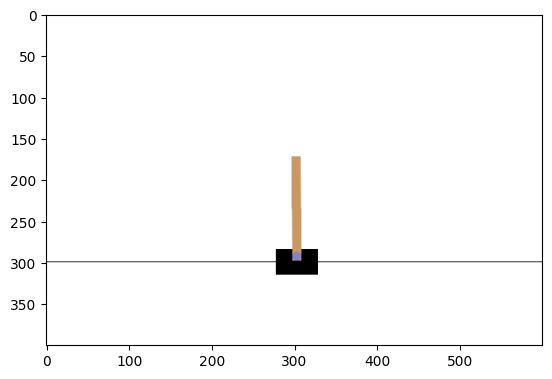

In [4]:
if not RENDER_LIVE: plt.imshow(env.render())  # observe slant to left

In [5]:
env.action_space

Discrete(2)

In [6]:
obs, reward, term, trunc, info = env.step(0)  # pole leans left so we step to the left
display(obs)  # angular velocity now positive, angle still negative
display(reward)
display(term)
display(trunc)
display(info)

obs, reward, term, trunc, info = env.step(0)  # step again
display(obs)  # angle now positive
display(reward)
display(term)
display(trunc)
display(info)

array([ 0.02468754, -0.16970496, -0.0042745 ,  0.25195482], dtype=float32)

1.0

False

False

{}

array([ 0.02129344, -0.3647656 ,  0.0007646 ,  0.54328644], dtype=float32)

1.0

False

False

{}

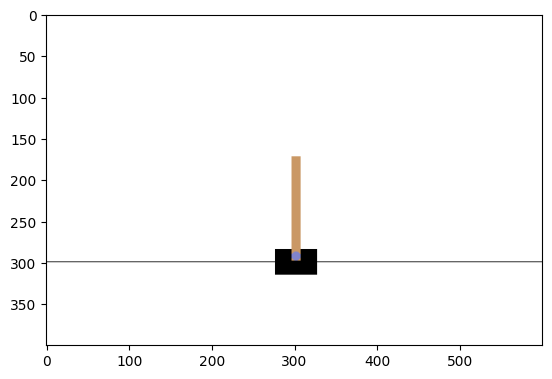

In [7]:
if not RENDER_LIVE: plt.imshow(env.render())  # now pole leans to the right

Reward is: `1.0` as long as you're alive. Let's try a simple random policy:

In [8]:
def test_episodes(env, policy, episodes=None, steps_per_episode=200):
    if episodes is None: episodes = EPISODES
    results = []
    for episode in range(episodes):
        episode_rewards = 0
        obs, _ = env.reset()
        for step in range(steps_per_episode):
            action = policy(obs)
            obs, reward, term, trunc, _ = env.step(action)
            episode_rewards += reward
            if term or trunc: break
        results.append(episode_rewards)
    print(f"Mean: {np.mean(results):.2f}, stdev: {np.std(results):.3f}, min: {np.min(results):.0f}, max: {np.max(results):.0f}")
    return results

In [9]:
def random_policy(obs):
    return env.action_space.sample()

test_episodes(env, random_policy);

Mean: 22.42, stdev: 12.158, min: 8, max: 114


Can we do better with a policy that always goes left if the stick leans left else right?

In [10]:
def naive_policy(obs):
    pos, lin_vel, angle, ang_vel = obs
    return 0 if angle < 0 else 1

test_episodes(env, naive_policy);

Mean: 42.04, stdev: 8.956, min: 24, max: 72


It's too underdamped. How about decreasing the `p` term by adding some noise?

In [11]:
def pd_angle_policy(obs):
    pos, lin_vel, angle, ang_vel = obs
    p = 0.8
    if random.random() > p:
        return env.action_space.sample()
    else:
        return 0 if angle < 0 else 1

test_episodes(env, pd_angle_policy);

Mean: 44.71, stdev: 19.327, min: 11, max: 151


We could do better — the next step might be to add a `d` term based on linear velocity or angular velocity. But let's move on to a neural network.

## Policy Gradients

In [12]:
import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn

In [13]:
n_inputs = env.observation_space.shape[0]  # 4 inputs

def create_blank_model_tf():
    return keras.models.Sequential([
        keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

model_tf = create_blank_model_tf()
display(model_tf.summary())
display(model_tf.weights)

def create_blank_model_torch():
    return nn.Sequential(
        nn.Linear(n_inputs, 5),
        nn.ELU(),
        nn.Linear(5, 1),
        nn.Sigmoid()
    )

model_torch = create_blank_model_torch()
display(model_torch)
display(list(model_torch.parameters()))

/Users/gkonars/Documents/JuliaProjects/S-NSAI/nsai_experiments/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

None

[<Variable path=sequential/dense/kernel, shape=(4, 5), dtype=float32, value=[[-0.10843611  0.50736547 -0.21464926 -0.8145032  -0.03049356]
  [-0.6752617  -0.12508917 -0.536371   -0.35374147  0.20985699]
  [ 0.20987117 -0.4302127   0.14113915  0.22847998  0.06176913]
  [-0.52206755 -0.7731822   0.7651123   0.61835504  0.20476067]]>,
 <Variable path=sequential/dense/bias, shape=(5,), dtype=float32, value=[0. 0. 0. 0. 0.]>,
 <Variable path=sequential/dense_1/kernel, shape=(5, 1), dtype=float32, value=[[-0.21085691]
  [-0.32191586]
  [ 0.92109966]
  [-0.71478844]
  [-0.9048376 ]]>,
 <Variable path=sequential/dense_1/bias, shape=(1,), dtype=float32, value=[0.]>]

Sequential(
  (0): Linear(in_features=4, out_features=5, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)

[Parameter containing:
 tensor([[-0.4193,  0.4060, -0.4715,  0.0988],
         [ 0.4094, -0.0235, -0.2051,  0.2446],
         [ 0.4783,  0.1458, -0.1990,  0.1497],
         [-0.4315, -0.1876, -0.4553,  0.2262],
         [ 0.2440, -0.0455,  0.4933,  0.2466]], requires_grad=True),
 Parameter containing:
 tensor([-0.2686,  0.0694, -0.2038, -0.3691, -0.4247], requires_grad=True),
 Parameter containing:
 tensor([[-0.0060,  0.1005,  0.2764, -0.4001,  0.1831]], requires_grad=True),
 Parameter containing:
 tensor([0.2432], requires_grad=True)]

In [14]:
def play_one_step_tf(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_p = model(obs[np.newaxis])  # reshape so it looks like a batch
        action = (tf.random.uniform([1, 1]) > left_p)  # if left_p is high, action is likely to be 0
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)  # *here we assume that `action` is correct*
        loss = tf.reduce_mean(loss_fn(y_target, left_p))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, term, trunc, info = env.step(int(action.numpy()[0, 0]))
    return obs, reward, (term or trunc), grads

obs, _ = env.reset(seed=47)
tf.keras.utils.set_random_seed(47)
print("\n".join(map(str, play_one_step_tf(env, obs, create_blank_model_tf(), keras.losses.binary_crossentropy))))
print("\n\n")

def play_one_step_torch(env, obs, model, loss_fn):
    model.zero_grad()
    left_p = model(torch.from_numpy(obs[np.newaxis]))
    action = (torch.rand(1, 1) > left_p)
    y_target = torch.Tensor([[1.]]) - action.to(torch.float32)
    loss = nn.BCELoss()(left_p, y_target)  # note the order is swapped from Keras
    loss.backward()
    grads = [x.grad for x in model.parameters()]
    obs, reward, term, trunc, info = env.step(int(action.numpy()[0, 0]))
    return obs, reward, (term or trunc), grads

obs, _ = env.reset(seed=47)
torch.manual_seed(47)
print("\n".join(map(str, play_one_step_torch(env, obs, create_blank_model_torch(), nn.BCELoss()))))


[ 0.02468754  0.22053859 -0.0042745  -0.33340698]
1.0
False
[<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[-0.00967987,  0.00755952, -0.00462661, -0.00201059, -0.00621639],
       [-0.01015493,  0.00793052, -0.00485367, -0.00210927, -0.00652147],
       [ 0.0013939 , -0.00108857,  0.00066623,  0.00028953,  0.00089516],
       [ 0.01586377, -0.01238886,  0.00758228,  0.00329504,  0.01018767]],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.40032217,  0.31263286, -0.19133899, -0.08315041, -0.25708586],
      dtype=float32)>, <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.0132117 ],
       [-0.00387051],
       [ 0.00569023],
       [-0.0115659 ],
       [-0.00113218]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.49351227], dtype=float32)>]



[ 0.02468754  0.22053859 -0.0042745  -0.33340698]
1.0
False
[tensor([[ 0.0028,  0.0030, -0.0004, -0.0046],
        [ 0.0050,  0.0052, -0.0007, -0.0081],
        [-0.002

So basically above we're just capturing what the gradients would be if this was a good move. Later we'll flip them around depending on whether it actually was a good move.

In [15]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    play_one_step = play_one_step_torch if isinstance(model, nn.Module) else play_one_step_tf
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        my_rewards = []
        my_grads = []
        obs, _ = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            my_rewards.append(reward)
            my_grads.append(grads)
            if done: break
        all_rewards.append(my_rewards)
        all_grads.append(my_grads)
    return all_rewards, all_grads

env.reset(seed=47)
tf.keras.utils.set_random_seed(47)
print(play_multiple_episodes(env, 5, 50, model_tf, keras.losses.binary_crossentropy))
print("\n\n")

env.reset(seed=47)
torch.manual_seed(47)
print(play_multiple_episodes(env, 5, 50, model_torch, nn.BCELoss()))

([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [[[<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[-0.00491298, -0.00763633,  0.02184987, -0.0166799 , -0.02146411],
       [ 0.00188636,  0.002932  , -0.00838935,  0.00640431,  0.00824123],
       [ 0.0031536 ,  0.0049017 , -0.01402525,  0.01070669,  0.01377764],
       [-0.00376493, -0.00585189,  0.01674405, -0.01278218, -0.01644843]],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.10523646, -0.16357069,  0.4680257 , -0.35728458, -0.4597627 ],
      dtype=float32)>, <tf.

In [16]:
def discount_rewards(rewards, discount_factor):
    # discounted = np.array(rewards)
    discounted = np.array(rewards, dtype=np.float32)
    # Walk backwards through rewards, accumulating discounted messages from the future
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step+1]*discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flattened_rewards = np.concatenate(all_discounted)
    # print(all_discounted)
    reward_mean, reward_stdev = flattened_rewards.mean(), flattened_rewards.std()
    return [(discounted - reward_mean) / reward_stdev for discounted in all_discounted]

display(discount_rewards([10, 0, -50], discount_factor=0.8))
display(discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8))
display(discount_and_normalize_rewards([[1, 1, 1, 1, 1, 1], [1, 1, 1]], discount_factor=0.8))

array([-22., -40., -50.], dtype=float32)

[array([-0.28435072, -0.86597717, -1.189103  ], dtype=float32),
 array([1.2666533, 1.0727777], dtype=float32)]

[array([ 1.5591382 ,  1.1976715 ,  0.74583846,  0.18104705, -0.5249422 ,
        -1.4074286 ], dtype=float32),
 array([ 0.18104705, -0.5249422 , -1.4074286 ], dtype=float32)]

Okay so I guess since we only get positive feedback the discounting and normalization turns short runs into punishments and long runs into rewards, since longer runs have a longer time to accumulate.

In [17]:
# If concerns about reproducibility:
# keras.backend.clear_session()
# np.random.seed(42)
# tf.random.set_seed(42)
# tf.keras.utils.set_random_seed(42)

# model = keras.models.Sequential([
#     keras.layers.Dense(5, activation="elu", input_shape=[4]),
#     keras.layers.Dense(1, activation="sigmoid"),
# ])
# print(model.weights)

# print(env, n_episodes_per_update, n_max_steps, model, loss_fn)

# print("\n\nOne step:")
# env = gym.make("CartPole-v1")
# obs, _ = env.reset(seed=42)
# print(play_one_step(env, obs, model, loss_fn))

In [18]:
n_iterations = 150  # 150 iterations takes about 6m30 with TensorFlow, 25s with PyTorch (TODO why is Torch SOOOO much faster?)
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

def train_tf(env, model, loss_fn, optimizer):
    for iteration in range(n_iterations):
        all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
        total_rewards = sum(map(sum, all_rewards))
        print(f"\rIteration {iteration}, mean rewards: {total_rewards/n_episodes_per_update:.1f}", end="")
        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
        all_mean_grads = []
        for var_i in range(len(model.trainable_variables)):
            mean_grads = tf.reduce_mean([final_reward * all_grads[episode_i][step][var_i]
                                        for episode_i, final_rewards in enumerate(all_final_rewards)
                                            for step, final_reward in enumerate(final_rewards)], axis=0)
            all_mean_grads.append(mean_grads)
        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

keras.backend.clear_session()
env = gym.make("CartPole-v1")
model_tf = create_blank_model_tf()
optimizer_tf = keras.optimizers.Adam(learning_rate=0.01)
loss_fn_tf = keras.losses.binary_crossentropy
train_tf(env, model_tf, loss_fn_tf, optimizer_tf)

def train_torch(env, model, loss_fn, optimizer):
    for iteration in range(n_iterations):
        all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
        total_rewards = sum(map(sum, all_rewards))
        print(f"\rIteration {iteration}, mean rewards: {total_rewards/n_episodes_per_update:.1f}", end="")
        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
        all_mean_grads = []
        optimizer.zero_grad()
        for var_i, var in enumerate(model.parameters()):
            my_grad = torch.mean(torch.stack([final_reward * all_grads[episode_i][step][var_i]
                                               for episode_i, final_rewards in enumerate(all_final_rewards)
                                                for step, final_reward in enumerate(final_rewards)]), axis = 0)
            var.grad = my_grad
        optimizer.step()

env = gym.make("CartPole-v1")
model_torch = create_blank_model_torch()
optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=0.01)
loss_fn_torch = nn.BCELoss()
train_torch(env, model_torch, loss_fn_torch, optimizer_torch)

Iteration 149, mean rewards: 187.2

## Rest

In [19]:
def nn_policy(model, randomness = 0.5):
    def specialized_nn_policy(obs):
        obs = obs[np.newaxis]
        left_p = (model(torch.from_numpy(obs)).detach() if isinstance(model, nn.Module) else model(obs)).numpy()[0, 0]
        sampler = random.random()*randomness+0.5*(1-randomness)
        action = 0 if (sampler < left_p) else 1
        return action
    return specialized_nn_policy

# When trained with 50 iterations, there are significant differences here. I'd guess the optimizer is doing slightly different things.
test_episodes(env, nn_policy(model_tf), episodes=50);
test_episodes(env, nn_policy(model_torch), episodes=50);

Mean: 199.30, stdev: 4.759, min: 166, max: 200
Mean: 200.00, stdev: 0.000, min: 200, max: 200
